In [1]:
import os, sys
project_root = os.path.abspath(os.path.join(os.getcwd(), '..'))
if project_root not in sys.path:
    sys.path.insert(0, project_root)

In [2]:
cd ..

/Users/alex/Code/robust-AI-verification


# IndPenSim Dataset EDA for Forecasting Validation

This notebook explores the Industrial Penicillin Simulation (IndPenSim) dataset to determine its suitability for time series forecasting.

## 1. Setup & Configuration

In [3]:
import os
import sys
from pathlib import Path

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.graph_objects as go
import plotly.express as px

# Set plotting style
sns.set_style("whitegrid")
plt.rcParams["figure.figsize"] = (14, 6)

# Suppress warnings for cleaner output
import warnings
warnings.filterwarnings("ignore")

print("Libraries loaded successfully!")

Libraries loaded successfully!


## 2. Load Data from CSV

In [4]:
# Define path
RAW_CSV = Path("data/raw/penicillin/IndPenSim_V2_export_V7.csv")

print("=" * 80)
print("LOADING FROM CSV")
print("=" * 80)

print(f"\nCSV file: {RAW_CSV}")
print(f"Exists: {RAW_CSV.exists()}")

if not RAW_CSV.exists():
    raise FileNotFoundError(f"CSV file not found: {RAW_CSV}")

print("\nLoading data... (this may take 10-20 seconds for 100MB file)")
df = pd.read_csv(RAW_CSV)

print(f"\nCSV loaded successfully!")
print(f"  Shape: {df.shape}")
print(f"  Memory usage: {df.memory_usage(deep=True).sum() / 1024**2:.1f} MB")
print(f"\nFirst few rows:")
df.head()

LOADING FROM CSV

CSV file: data/raw/penicillin/IndPenSim_V2_export_V7.csv
Exists: True

Loading data... (this may take 10-20 seconds for 100MB file)

CSV loaded successfully!
  Shape: (576580, 36)
  Memory usage: 158.4 MB

First few rows:


,Time (h),Fg,RPM,Fs,Fa,Fb,Fc,Fh,Fw,pressure,...,P_offline,X_offline,CER,NH3_shots,Viscosity_offline,Fault_ref,Control_ref,PAT_ref,Batch_ref,Batch_ref.1
0,0.2,30,100,8,0.0,0.0000,0.0001,281.5000,0,0.6,...,NaN,NaN,0.029993,0,NaN,0,0,0,0,1
1,0.4,30,100,8,0.0,0.0000,0.0001,83.4630,0,0.6,...,NaN,NaN,0.033747,0,NaN,0,0,0,0,1
2,0.6,30,100,8,0.0,0.0000,0.0001,0.0001,0,0.6,...,NaN,NaN,0.034995,0,NaN,0,0,0,0,1
3,0.8,30,100,8,0.0,0.0000,0.0001,110.1900,0,0.6,...,NaN,NaN,0.035747,0,NaN,0,0,0,0,1
4,1.0,30,100,8,0.0,6.1264,118.8200,11.0190,0,0.6,...,0.001,0.45301,0.036422,0,4.0789,0,0,0,0,1


## 3. Understand Data Structure

In [5]:
print("Dataset structure:")
print(f"\nColumns ({len(df.columns)}):")
for i, col in enumerate(df.columns, 1):
    print(f"  {i:2d}. {col}")

print(f"\nNumber of batches: {df['Batch_ref.1'].nunique()}")
print(f"Batch ID range: {df['Batch_ref.1'].min()} to {df['Batch_ref.1'].max()}")
print(f"\nTime range: {df['Time (h)'].min():.1f} to {df['Time (h)'].max():.1f} hours")
print(f"Sampling interval: {df['Time (h)'].diff().median():.2f} hours (= {df['Time (h)'].diff().median() * 60:.0f} minutes)")

Dataset structure:

Columns (36):
   1. Time (h)
   2. Fg
   3. RPM
   4. Fs
   5. Fa
   6. Fb
   7. Fc
   8. Fh
   9. Fw
  10. pressure
  11. Fremoved
  12. S
  13. DO2
  14. P
  15. V
  16. Wt
  17. pH
  18. T
  19. Q
  20. CO2outgas
  21. Fpaa
  22. PAA_offline
  23. Foil
  24. NH3_offline
  25. OUR
  26. O2
  27. P_offline
  28. X_offline
  29. CER
  30. NH3_shots
  31. Viscosity_offline
  32. Fault_ref
  33. Control_ref
  34. PAT_ref
  35. Batch_ref
  36. Batch_ref.1

Number of batches: 500
Batch ID range: 1 to 500

Time range: 0.2 to 304.0 hours
Sampling interval: 0.20 hours (= 12 minutes)


In [6]:
# Check batch lengths
batch_lengths = df.groupby('Batch_ref.1').size()

print("Batch length statistics:")
print(f"  Min: {batch_lengths.min()} samples")
print(f"  Max: {batch_lengths.max()} samples")
print(f"  Mean: {batch_lengths.mean():.1f} samples")
print(f"  Std: {batch_lengths.std():.1f} samples")

avg_duration_hours = batch_lengths.mean() * 0.2
avg_duration_days = avg_duration_hours / 24
print(f"\nAverage batch duration: {avg_duration_hours:.1f} hours ({avg_duration_days:.1f} days)")

Batch length statistics:
  Min: 780 samples
  Max: 1520 samples
  Mean: 1153.2 samples
  Std: 125.5 samples

Average batch duration: 230.6 hours (9.6 days)


## 4. Check for Missing Values (NaNs)

In [7]:
print("=" * 80)
print("MISSING DATA ANALYSIS")
print("=" * 80)

# Calculate missing percentages for all columns
missing_stats = pd.DataFrame({
    'column': df.columns,
    'missing_count': df.isnull().sum().values,
    'missing_percent': (df.isnull().sum() / len(df) * 100).values
})

missing_stats = missing_stats.sort_values('missing_percent', ascending=False)

print("\nColumns with missing values:")
missing_cols = missing_stats[missing_stats['missing_count'] > 0]
if len(missing_cols) > 0:
    for _, row in missing_cols.iterrows():
        print(f"  {row['column']:30s}: {row['missing_count']:8,.0f} ({row['missing_percent']:5.2f}%)")
else:
    print("  No missing values found!")

print(f"\nColumns with NO missing values: {len(missing_stats[missing_stats['missing_count'] == 0])}")
print(f"Columns WITH missing values: {len(missing_cols)}")

MISSING DATA ANALYSIS

Columns with missing values:
  X_offline                     :  566,240 (98.21%)
  P_offline                     :  566,240 (98.21%)
  PAA_offline                   :  566,240 (98.21%)
  NH3_offline                   :  566,240 (98.21%)
  Viscosity_offline             :  566,240 (98.21%)

Columns with NO missing values: 31
Columns WITH missing values: 5


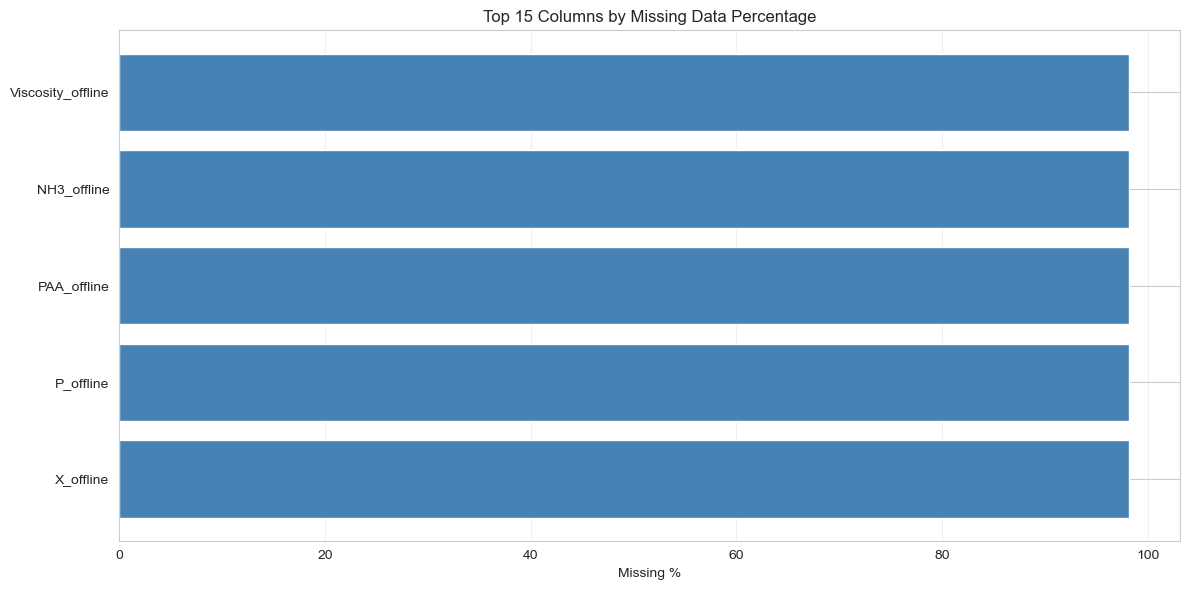

In [8]:
# Visualize missing data pattern
if len(missing_cols) > 0:
    fig, ax = plt.subplots(figsize=(12, 6))
    top_missing = missing_cols.head(15)
    ax.barh(top_missing['column'], top_missing['missing_percent'], color='steelblue')
    ax.set_xlabel('Missing %')
    ax.set_title('Top 15 Columns by Missing Data Percentage')
    ax.grid(alpha=0.3, axis='x')
    plt.tight_layout()
    plt.show()

### 4.1 Comprehensive NaN Analysis

In [9]:
missing_by_col = pd.DataFrame({
    'column': df.columns,
    'missing_count': df.isnull().sum().values,
    'missing_percent': (df.isnull().sum() / len(df) * 100).values,
    'present_count': df.notnull().sum().values,
    'present_percent': (df.notnull().sum() / len(df) * 100).values
}).sort_values('missing_percent', ascending=False)

print(f"\nTotal columns: {len(missing_by_col)}")
print(f"Columns with missing data: {(missing_by_col['missing_count'] > 0).sum()}")
print(f"Columns with NO missing data: {(missing_by_col['missing_count'] == 0).sum()}")

print("\n" + "-" * 80)
print("ALL COLUMNS WITH MISSING DATA:")
print("-" * 80)
cols_with_missing = missing_by_col[missing_by_col['missing_count'] > 0]
for idx, row in cols_with_missing.iterrows():
    print(f"{row['column']:35s} | Missing: {row['missing_count']:8,.0f} ({row['missing_percent']:6.2f}%) | Present: {row['present_count']:8,.0f} ({row['present_percent']:6.2f}%)")

print("\n" + "-" * 80)
print("COLUMNS WITH NO MISSING DATA (sample):")
print("-" * 80)
cols_no_missing = missing_by_col[missing_by_col['missing_count'] == 0].head(10)
for idx, row in cols_no_missing.iterrows():
    print(f"{row['column']:35s} | Complete: {row['present_count']:8,.0f} (100.00%)")
if len(missing_by_col[missing_by_col['missing_count'] == 0]) > 10:
    print(f"... and {len(missing_by_col[missing_by_col['missing_count'] == 0]) - 10} more complete columns")


Total columns: 36
Columns with missing data: 5
Columns with NO missing data: 31

--------------------------------------------------------------------------------
ALL COLUMNS WITH MISSING DATA:
--------------------------------------------------------------------------------
X_offline                           | Missing:  566,240 ( 98.21%) | Present:   10,340 (  1.79%)
P_offline                           | Missing:  566,240 ( 98.21%) | Present:   10,340 (  1.79%)
PAA_offline                         | Missing:  566,240 ( 98.21%) | Present:   10,340 (  1.79%)
NH3_offline                         | Missing:  566,240 ( 98.21%) | Present:   10,340 (  1.79%)
Viscosity_offline                   | Missing:  566,240 ( 98.21%) | Present:   10,340 (  1.79%)

--------------------------------------------------------------------------------
COLUMNS WITH NO MISSING DATA (sample):
--------------------------------------------------------------------------------
Fpaa                                | Compl

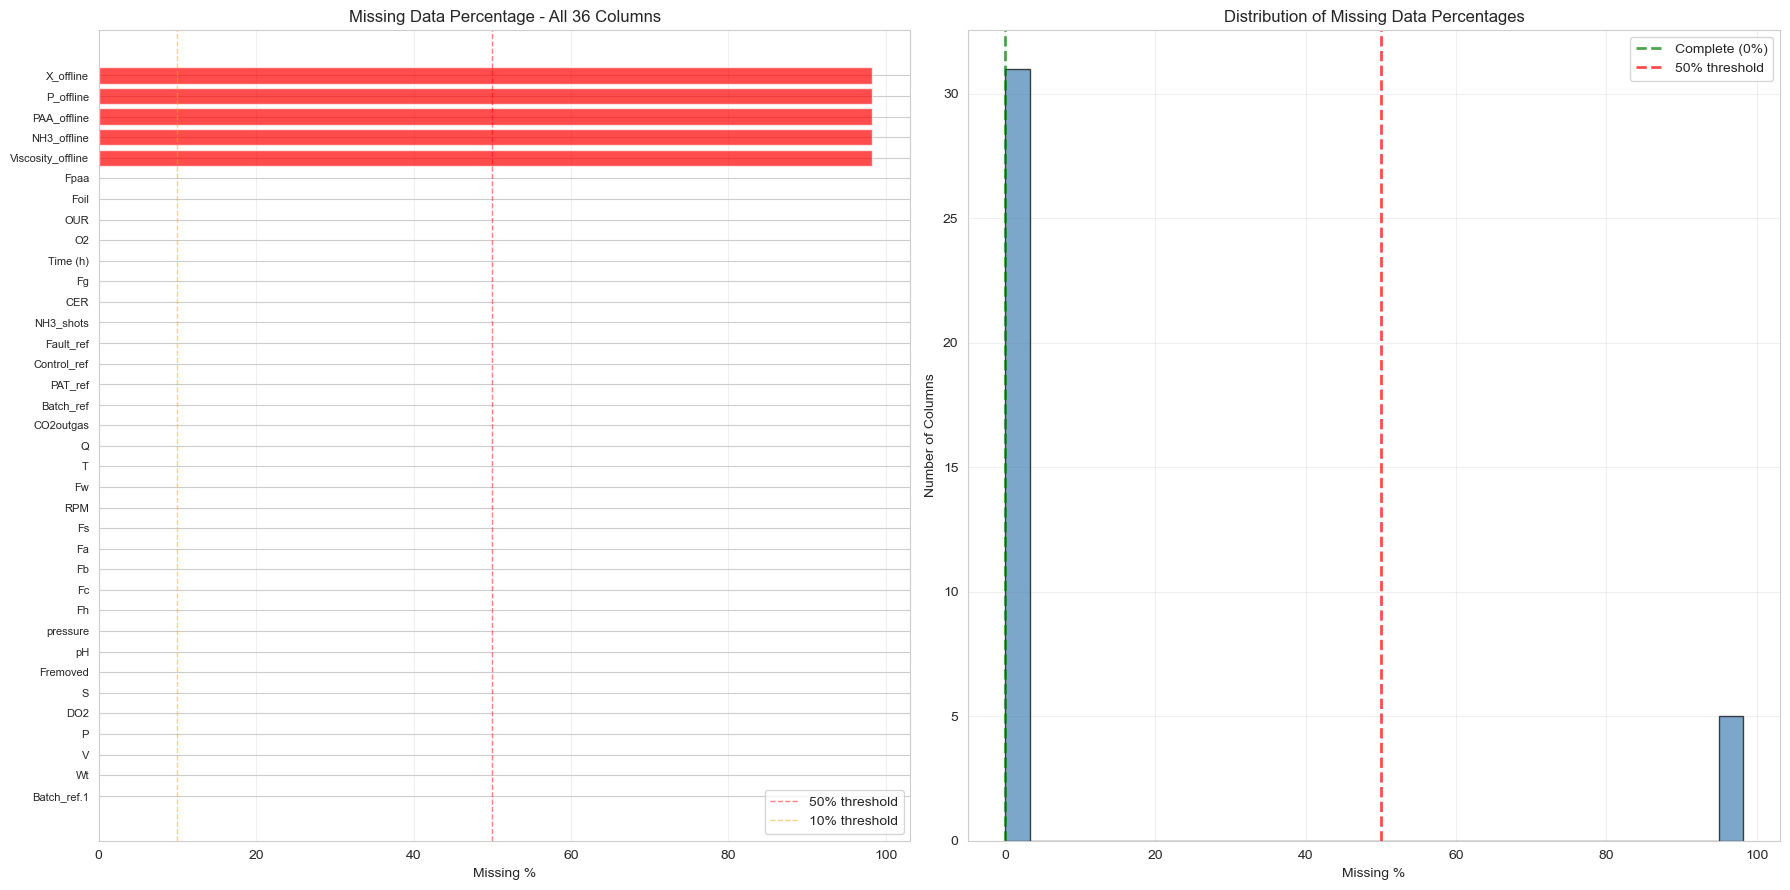


Missing data percentage distribution:
count    36.000000
mean     13.639815
std      34.444632
min       0.000000
25%       0.000000
50%       0.000000
75%       0.000000
max      98.206667
Name: missing_percent, dtype: float64


In [10]:
# 2. Visualize missing data by ALL columns
fig, axes = plt.subplots(1, 2, figsize=(18, max(8, len(missing_by_col) * 0.25)))

# Plot 1: Missing percentage for ALL columns
ax1 = axes[0]
y_pos = np.arange(len(missing_by_col))
colors = ['red' if x > 50 else 'orange' if x > 10 else 'yellow' if x > 0 else 'green' 
          for x in missing_by_col['missing_percent']]
ax1.barh(y_pos, missing_by_col['missing_percent'], color=colors, alpha=0.7)
ax1.set_yticks(y_pos)
ax1.set_yticklabels(missing_by_col['column'], fontsize=8)
ax1.set_xlabel('Missing %')
ax1.set_title(f'Missing Data Percentage - All {len(missing_by_col)} Columns')
ax1.axvline(x=50, color='red', linestyle='--', alpha=0.5, linewidth=1, label='50% threshold')
ax1.axvline(x=10, color='orange', linestyle='--', alpha=0.5, linewidth=1, label='10% threshold')
ax1.grid(alpha=0.3, axis='x')
ax1.legend()
ax1.invert_yaxis()

# Plot 2: Distribution of missing percentages
ax2 = axes[1]
ax2.hist(missing_by_col['missing_percent'], bins=30, color='steelblue', alpha=0.7, edgecolor='black')
ax2.set_xlabel('Missing %')
ax2.set_ylabel('Number of Columns')
ax2.set_title('Distribution of Missing Data Percentages')
ax2.axvline(x=0, color='green', linestyle='--', alpha=0.7, linewidth=2, label='Complete (0%)')
ax2.axvline(x=50, color='red', linestyle='--', alpha=0.7, linewidth=2, label='50% threshold')
ax2.grid(alpha=0.3)
ax2.legend()

plt.tight_layout()
plt.show()

# Summary statistics
print("\nMissing data percentage distribution:")
print(missing_by_col['missing_percent'].describe())

so only offline data is missing most of the time

## 5. Summary Statistics

In [11]:
print("=" * 80)
print("SUMMARY STATISTICS")
print("=" * 80)

# Select key numerical columns
key_cols = ['P', 'T', 'pH', 'DO2', 'Wt', 'CO2outgas', 'O2', 'Fa', 'Fb', 'Fc']
available_cols = [col for col in key_cols if col in df.columns]

stats = df[available_cols].describe()
stats

SUMMARY STATISTICS


,P,T,pH,DO2,Wt,CO2outgas,O2,Fa,Fb,Fc
count,5.765800e+05,576580.000000,576580.000000,576580.000000,576580.000000,576580.000000,576580.000000,576580.000000,576580.000000,576580.000000
mean,1.477330e+01,298.022542,6.498874,12.630908,81537.278289,1.445006,0.191421,0.075769,62.866146,74.210979
std,9.853650e+00,0.180100,0.053332,1.435637,10145.584812,0.461206,0.004184,0.561472,45.903605,127.279188
min,5.904600e-28,297.330000,5.083100,2.163800,60562.000000,0.071564,0.143350,0.000000,0.000000,0.000100
25%,5.905275e+00,297.950000,6.492900,11.716000,73764.000000,1.263900,0.188930,0.000000,37.224000,10.378000
50%,1.559700e+01,297.990000,6.500900,12.673000,84929.000000,1.594800,0.191050,0.000000,56.035000,31.742000
75%,2.277000e+01,298.040000,6.508900,13.666000,89101.000000,1.752000,0.193640,0.000000,78.159000,88.559500
max,3.637200e+01,302.830000,6.840800,16.740000,106880.000000,2.274700,0.232380,13.514000,225.000000,1500.000000


In [12]:
print("\nData characteristics:")
print(f"  Total samples: {len(df):,}")
print(f"  Number of batches: {df['Batch_ref.1'].nunique()}")
print(f"  Average batch length: {batch_lengths.mean():.1f} samples")
print(f"  Average batch duration: {avg_duration_hours:.1f} hours ({avg_duration_days:.1f} days)")
print(f"  Sampling interval: 12 minutes (0.2 hours)")
print(f"  Total time span: {df['Time (h)'].max():.1f} hours")


Data characteristics:
  Total samples: 576,580
  Number of batches: 500
  Average batch length: 1153.2 samples
  Average batch duration: 230.6 hours (9.6 days)
  Sampling interval: 12 minutes (0.2 hours)
  Total time span: 304.0 hours


## 6. Batch-to-Batch Drift Visualization

We overlay full batch trajectories with seaborn line plots (color-coded by batch) to inspect drift patterns in key online channels. Adjust `max_batches` in the cell below if you need to display more or fewer batches for readability.


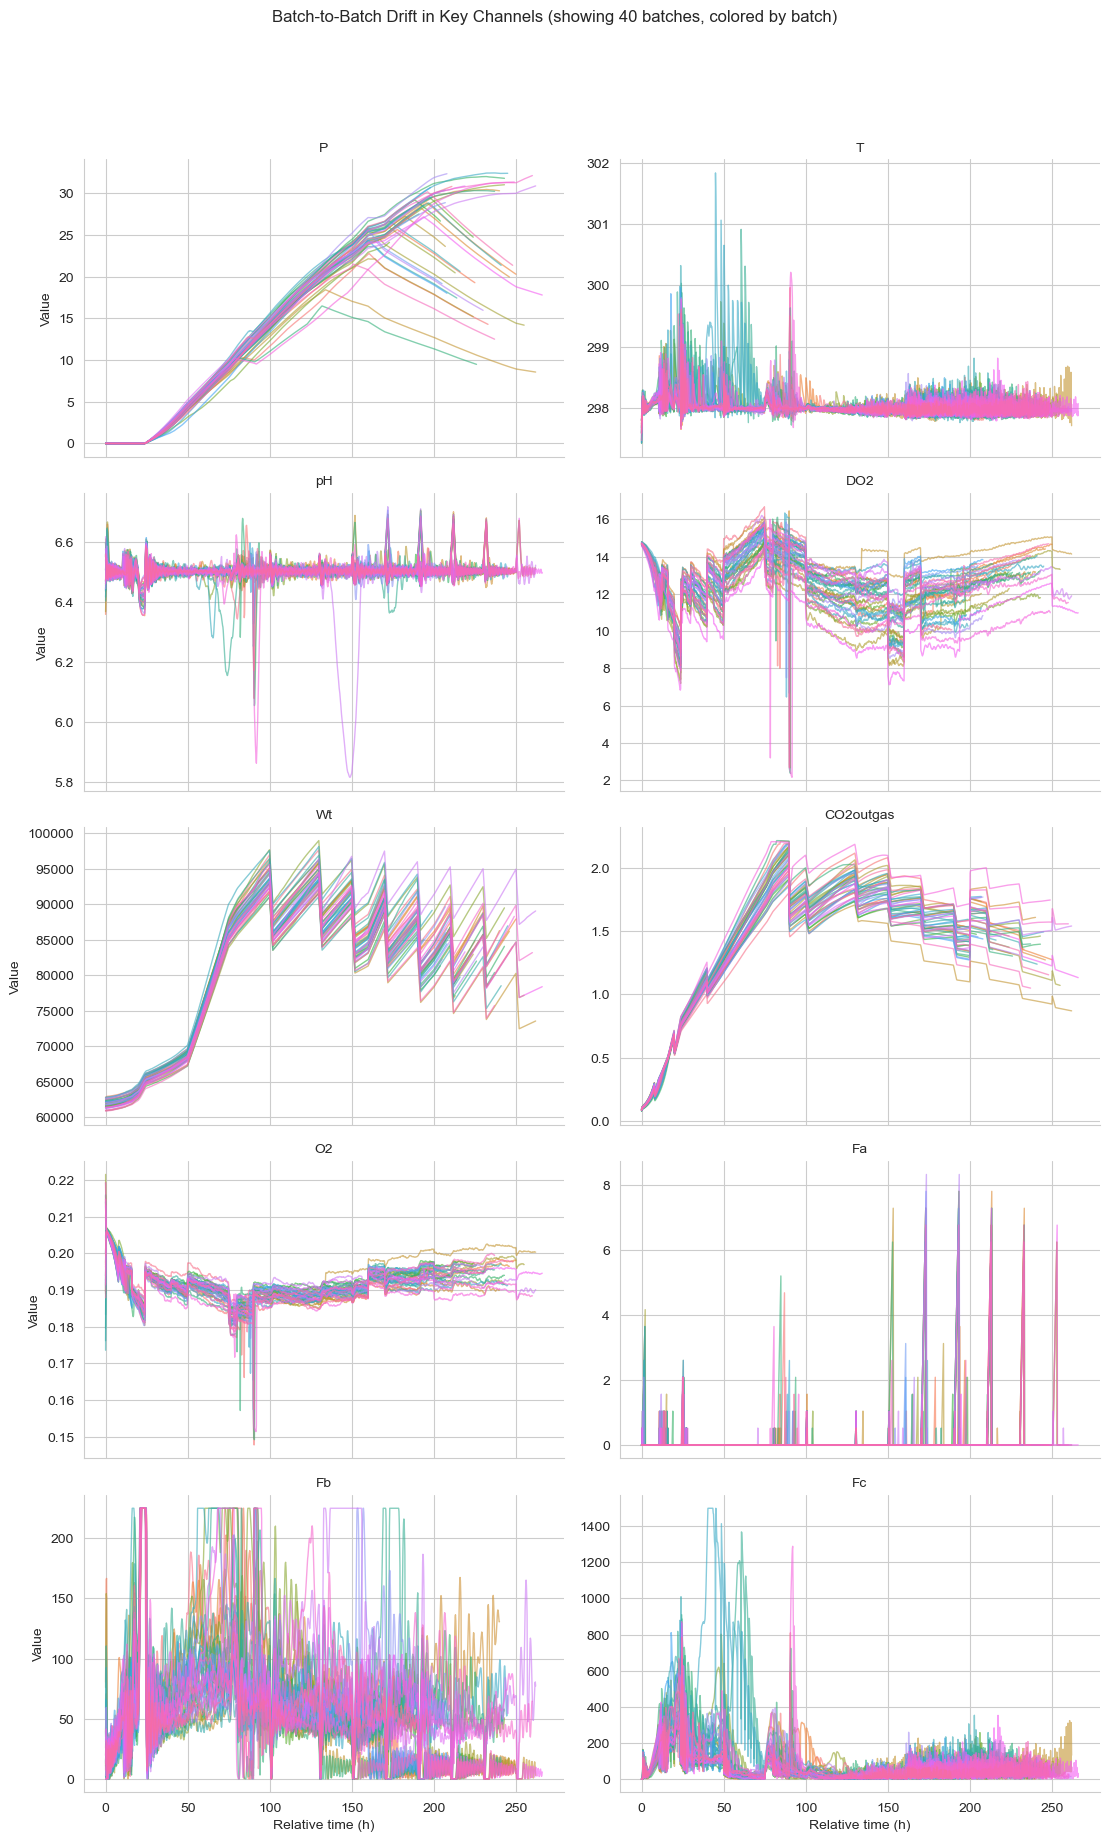

In [13]:
key_channels = ['P', 'T', 'pH', 'DO2', 'Wt', 'CO2outgas', 'O2', 'Fa', 'Fb', 'Fc']
available_channels = [col for col in key_channels if col in df.columns]

if not available_channels:
    raise ValueError('None of the key channels are present in the dataframe for drift visualization.')

plot_df = df[['Batch_ref.1', 'Time (h)'] + available_channels].copy()
plot_df = plot_df.rename(columns={'Batch_ref.1': 'batch_id', 'Time (h)': 'time_h'})
plot_df['relative_time_h'] = plot_df.groupby('batch_id')['time_h'].transform(lambda s: s - s.min())

max_batches = 40
unique_batches = plot_df['batch_id'].unique()
if len(unique_batches) > max_batches:
    selected_batches = unique_batches[:max_batches]
    plot_df = plot_df[plot_df['batch_id'].isin(selected_batches)]
else:
    selected_batches = unique_batches

long_df = plot_df.melt(
    id_vars=['batch_id', 'relative_time_h'],
    value_vars=available_channels,
    var_name='channel',
    value_name='value'
)

palette = sns.color_palette('husl', n_colors=len(selected_batches))
batch_palette = {batch: palette[idx] for idx, batch in enumerate(selected_batches)}

rel = sns.relplot(
    data=long_df,
    x='relative_time_h',
    y='value',
    hue='batch_id',
    kind='line',
    estimator=None,
    sort=False,
    col='channel',
    col_wrap=2,
    height=3.5,
    aspect=1.6,
    linewidth=1,
    alpha=0.6,
    palette=batch_palette,
    legend=False,
    facet_kws={'sharey': False}
)
rel.set_axis_labels('Relative time (h)', 'Value')
rel.set_titles('{col_name}')
rel.fig.suptitle(
    f'Batch-to-Batch Drift in Key Channels (showing {len(selected_batches)} batches, colored by batch)',
    y=1.05
)
plt.tight_layout()
plt.show()


## 7. Export Clean Forecasting Dataset
We drop sparsely populated offline assay columns, rename critical identifiers, and persist the cleaned multi-batch table in `data/processed/indpensim.parquet` so the training pipeline can ingest it directly.

In [14]:
from pathlib import Path

OFFLINE_COLUMNS = [
    "PAA_offline",
    "NH3_offline",
    "P_offline",
    "X_offline",
    "Viscosity_offline",
]
RENAME_MAP = {
    "Time (h)": "time_since_inoculation",
    "Batch_ref.1": "batch_id",
    "Fg": "Fg_aeration",
    "RPM": "agitator_rpm",
    "Fs": "Fs_substrate",
    "Fa": "Fa_acid",
    "Fb": "Fb_base",
    "Fpaa": "F_PAA",
    "Foil": "F_oil",
    "Fc": "Fc_cold_water",
    "Fh": "Fh_hot_water",
    "Fw": "Fw_dilution",
    "DO2": "dissolved_oxygen",
    "T": "temperature",
    "CO2outgas": "offgas_CO2_pct",
    "O2": "offgas_O2_pct",
    "V": "vessel_volume",
    "P": "penicillin_concentration",
    "Control_ref": "control_mode",
}
INPUT_COLUMNS = [
    "Fs_substrate",
    "Fa_acid",
    "Fb_base",
    "F_PAA",
    "F_oil",
    "Fg_aeration",
    "agitator_rpm",
    "Fh_hot_water",
    "Fc_cold_water",
    "Fw_dilution",
    "pH",
    "temperature",
    "dissolved_oxygen",
    "offgas_CO2_pct",
    "offgas_O2_pct",
    "vessel_volume",
    "pressure",
    "control_mode",
    "time_since_inoculation",
]
TARGET_COLUMN = "penicillin_concentration"
REQUIRED_COLUMNS = ["batch_id"] + INPUT_COLUMNS + [TARGET_COLUMN]
processed_path = Path("../data/processed/indpensim.parquet")

cols_to_drop = [col for col in OFFLINE_COLUMNS if col in df.columns]
if cols_to_drop:
    print(f"Dropping offline columns: {cols_to_drop}")
clean_df = df.drop(columns=cols_to_drop, errors="ignore").rename(columns=RENAME_MAP)

missing_required = sorted(set(REQUIRED_COLUMNS) - set(clean_df.columns))
if missing_required:
    raise ValueError(f"Missing required features after cleaning: {missing_required}")

export_df = clean_df.loc[:, REQUIRED_COLUMNS].copy()
export_df["batch_id"] = export_df["batch_id"].astype(int)
export_df.sort_values(["batch_id", "time_since_inoculation"], inplace=True)
export_df.reset_index(drop=True, inplace=True)

processed_path.parent.mkdir(parents=True, exist_ok=True)
export_df.to_parquet(processed_path, index=False)

print(
    f"Saved {len(export_df):,} rows across {export_df['batch_id'].nunique()} batches to {processed_path.resolve()}"
)
print(f"Columns exported: {export_df.columns.tolist()}")


Dropping offline columns: ['PAA_offline', 'NH3_offline', 'P_offline', 'X_offline', 'Viscosity_offline']
Saved 576,580 rows across 500 batches to /Users/alex/Code/data/processed/indpensim.parquet
Columns exported: ['batch_id', 'Fs_substrate', 'Fa_acid', 'Fb_base', 'F_PAA', 'F_oil', 'Fg_aeration', 'agitator_rpm', 'Fh_hot_water', 'Fc_cold_water', 'Fw_dilution', 'pH', 'temperature', 'dissolved_oxygen', 'offgas_CO2_pct', 'offgas_O2_pct', 'vessel_volume', 'pressure', 'control_mode', 'time_since_inoculation', 'penicillin_concentration']


## 8. Data Quality Statistics for Model Card

Compute and export data quality statistics that will be displayed in the IARC model card. This includes:
- Missingness rates per feature (before/after preprocessing)
- Summary statistics (mean, std, quantiles)
- Data characteristics (samples, batches, duration)
- Reproducibility info (seeds, environment)

In [15]:
import json
import platform
from datetime import datetime

# Compute data quality statistics for the model card
data_quality_stats = {
    "dataset_name": "IndPenSim",
    "dataset_version": "V2_export_V7",
    "source": "IndPenSim simulation (Goldrick et al., 2019)",
    "generated_at": datetime.now().isoformat(),
    
    # Raw data characteristics
    "raw_data": {
        "total_samples": int(df.shape[0]),
        "total_features": int(df.shape[1]),
        "num_batches": int(df['Batch_ref.1'].nunique()),
        "batch_id_range": [int(df['Batch_ref.1'].min()), int(df['Batch_ref.1'].max())],
        "sampling_interval_hours": float(df['Time (h)'].diff().median()),
        "sampling_interval_minutes": int(df['Time (h)'].diff().median() * 60),
        "time_range_hours": [float(df['Time (h)'].min()), float(df['Time (h)'].max())],
        "avg_batch_length_samples": float(batch_lengths.mean()),
        "avg_batch_duration_hours": float(batch_lengths.mean() * 0.2),
        "avg_batch_duration_days": float(batch_lengths.mean() * 0.2 / 24),
        "memory_usage_mb": float(df.memory_usage(deep=True).sum() / 1024**2),
    },
    
    # Missingness analysis (before preprocessing)
    "missingness_raw": {
        "columns_with_missing": int((df.isnull().sum() > 0).sum()),
        "columns_complete": int((df.isnull().sum() == 0).sum()),
        "missing_by_column": {
            col: {
                "missing_count": int(df[col].isnull().sum()),
                "missing_percent": float(df[col].isnull().sum() / len(df) * 100),
                "present_count": int(df[col].notnull().sum()),
            }
            for col in df.columns if df[col].isnull().sum() > 0
        },
        "note": "Only offline assay columns have missing values (~98%), online sensors are complete"
    },
    
    # After preprocessing (export_df)
    "missingness_processed": {
        "total_samples": int(len(export_df)),
        "total_features": int(len(export_df.columns)),
        "columns_with_missing": int((export_df.isnull().sum() > 0).sum()),
        "missing_rate_overall": float(export_df.isnull().sum().sum() / export_df.size * 100),
        "note": "Offline columns dropped; all remaining features are complete (0% missing)"
    },
    
    # Summary statistics for key features (processed data)
    "feature_statistics": {},
    
    # Reproducibility controls
    "reproducibility": {
        "random_seed_split": 42,
        "random_seed_training": 42,
        "python_version": platform.python_version(),
        "platform": platform.system(),
        "notebook": "data-indpensim.ipynb",
    }
}

# Add summary statistics for each feature in the exported dataset
for col in export_df.columns:
    if col == 'batch_id':
        continue
    series = export_df[col]
    data_quality_stats["feature_statistics"][col] = {
        "mean": float(series.mean()),
        "std": float(series.std()),
        "min": float(series.min()),
        "max": float(series.max()),
        "q05": float(series.quantile(0.05)),
        "q25": float(series.quantile(0.25)),
        "q50": float(series.quantile(0.50)),
        "q75": float(series.quantile(0.75)),
        "q95": float(series.quantile(0.95)),
        "missing_count": int(series.isnull().sum()),
        "missing_percent": float(series.isnull().sum() / len(series) * 100),
    }

# Save to JSON
stats_output_path = Path("../data/processed/indpensim_data_quality.json")
with open(stats_output_path, "w", encoding="utf-8") as f:
    json.dump(data_quality_stats, f, indent=2)

print(f"Data quality statistics saved to: {stats_output_path.resolve()}")
print(f"\nSummary:")
print(f"  Raw samples: {data_quality_stats['raw_data']['total_samples']:,}")
print(f"  Processed samples: {data_quality_stats['missingness_processed']['total_samples']:,}")
print(f"  Batches: {data_quality_stats['raw_data']['num_batches']}")
print(f"  Features (processed): {data_quality_stats['missingness_processed']['total_features']}")
print(f"  Missing rate (processed): {data_quality_stats['missingness_processed']['missing_rate_overall']:.2f}%")
print(f"  Sampling interval: {data_quality_stats['raw_data']['sampling_interval_minutes']} minutes")

Data quality statistics saved to: /Users/alex/Code/data/processed/indpensim_data_quality.json

Summary:
  Raw samples: 576,580
  Processed samples: 576,580
  Batches: 500
  Features (processed): 21
  Missing rate (processed): 0.00%
  Sampling interval: 12 minutes
